# Notebook per l'addestramento della rete convoluzionale sulle distribuzioni di voti

## Dataset ScenicOrNot



Si preparano innanzitutto gli array di features e di target, ridimensionando le immagini in 96x96

In [1]:
# importo sequenziale dei file .npy contenenti gli array di immagini e di voti

import numpy as np

features_files = [
    '/kaggle/input/d/federicasibilla/scenicornot/array_immagini224_completo11voti1.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_immagini224_completo11voti2.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_immagini224_completo11voti3.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_immagini224_completo11voti4.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_immagini224_completo11voti5.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_immagini224_completo11voti6.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_immagini224_completo11voti7.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_immagini224_completo11voti8.npy'
]
votes_files = [
    '/kaggle/input/d/federicasibilla/scenicornot/array_voti_completo11voti1.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_voti_completo11voti2.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_voti_completo11voti3.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_voti_completo11voti4.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_voti_completo11voti5.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_voti_completo11voti6.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_voti_completo11voti7.npy',
    '/kaggle/input/d/federicasibilla/scenicornot/array_voti_completo11voti8.npy'

]

features = []
votes = []

for features_file, votes_file in zip(features_files, votes_files):
    features_array = np.load(features_file, allow_pickle=True)
    votes_array = np.load(votes_file, allow_pickle=True)
    
    features.append(features_array)
    votes.append(votes_array)
    
    # Elimina gli array singoli
    del features_array, votes_array

# Concatena gli array
features = np.concatenate(features, axis=0)
votes = np.concatenate(votes, axis=0)

In [2]:
# il dataset completo concatenato contiene 22472 immagini (tutte quelle che hanno ricevuto più di 11 voti)

print(features.shape, votes.shape)

(22472, 224, 224, 3) (22472, 10)


In [3]:
# ridimensionamento immagini per velocizzare addestramento, si usano immagini 96x96

import tensorflow as tf

features_red = []

for i in range(len(features)):
    features_red.append(tf.image.resize(features[i,:,:,:], [96,96]))
features = np.array(features_red)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
features.shape

(22472, 96, 96, 3)

In [5]:
# riduzione dei valori di pixel tra 0 e 1

features  = features/255

Facendo riferimento al notebook 'ScenicOrNot_dataset', si nota che le classi sono notevolmente sbilanciate, con una sottorappresentazione delle classi a più alto punteggio, per questo motivo si procede ad un'augmentazione selettiva di queste classi. Si effettua l'augmentation una volta per 7,8,9,10 una seconda volta per 8,9,10 e infine una terza per 9,10, sperando di diminuire la riduzione progressiva di rappresentanti.

In [6]:
# augmentation delle classi da 7 in poi

import imgaug.augmenters as iaa

def augment_data(images, labels):
    augmenter = iaa.Sequential([                      # operazioni sequenziali applicate all'immagine prima di copiarla
        iaa.GaussianBlur(sigma=(0, 1.0)),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05)),
        iaa.Fliplr(0.5)
    ])
    
    augmented_images = list(images) 
    augmented_labels = list(labels)
    
    for i in range(len(images)):
        top_label = tf.argmax(labels,axis=1)+1
        if top_label[i] > 6:
            augmented_image = augmenter.augment_image(images[i,:,:,:])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])
    for i in range(len(images)):
        top_label = tf.argmax(labels,axis=1)+1
        if top_label[i] > 7:
            augmented_image = augmenter.augment_image(images[i,:,:,:])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])
    for i in range(len(images)):
        top_label = tf.argmax(labels,axis=1)+1
        if top_label[i] > 8:
            augmented_image = augmenter.augment_image(images[i,:,:,:])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])

    return np.array(augmented_images), np.array(augmented_labels)

aug_features, aug_votes = augment_data(features, votes)

In [7]:
del features
aug_features.shape

(27345, 96, 96, 3)

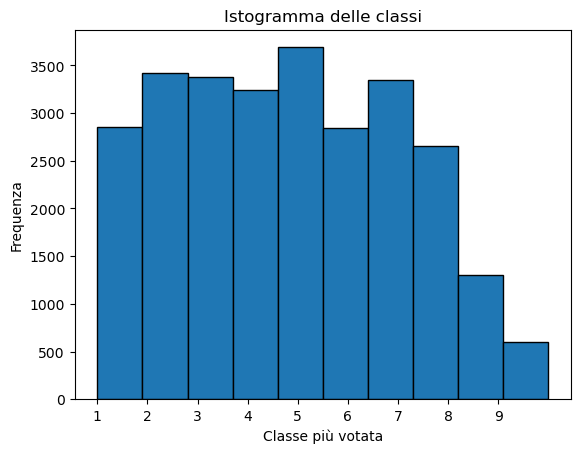

In [8]:
# distribuzione delle classi più votate 

import matplotlib.pyplot as plt

top_votes = np.argmax(aug_votes,axis=1)+1

# Creazione dell'istogramma
plt.hist(top_votes, bins=10, edgecolor='black')

plt.xlabel('Classe più votata')
plt.ylabel('Frequenza')
plt.title('Istogramma delle classi')
plt.xticks(np.arange(1, 10, 1))

plt.show()

In [9]:
# augmentation delle classi da 7 in poi

import imgaug.augmenters as iaa

def augment_data(images, labels):
    augmenter = iaa.Sequential([                      # operazioni sequenziali applicate all'immagine prima di copiarla
        iaa.GaussianBlur(sigma=(0, 1.0)),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05)),
        iaa.Fliplr(0.5)
    ])
    
    augmented_images = list(images) 
    augmented_labels = list(labels)
    
    for i in range(len(images)):
        top_label = tf.argmax(labels,axis=1)+1
        if (top_label[i] > 8 and np.random.random() < (0.2 * np.float64(top_label[i] - 3))):
            augmented_image = augmenter.augment_image(images[i,:,:,:])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])
    for i in range(len(images)):
        top_label = tf.argmax(labels,axis=1)+1
        if top_label[i] > 9:
            augmented_image = augmenter.augment_image(images[i,:,:,:])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])

    return np.array(augmented_images), np.array(augmented_labels)

aug_features, aug_votes = augment_data(aug_features, aug_votes)

In [10]:
aug_features.shape

(29857, 96, 96, 3)

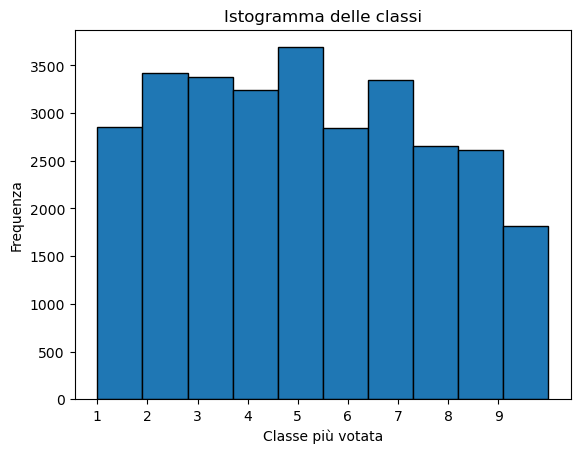

In [11]:
# distribuzione delle classi più votate 

import matplotlib.pyplot as plt

top_votes = np.argmax(aug_votes,axis=1)+1

# Creazione dell'istogramma
plt.hist(top_votes, bins=10, edgecolor='black')

plt.xlabel('Classe più votata')
plt.ylabel('Frequenza')
plt.title('Istogramma delle classi')
plt.xticks(np.arange(1, 10, 1))

plt.show()

Pur rimanendo sbilanciate, le proporzioni tra le classi sono migliorate

Si separa ora il dataset nei subset di addestramento, validazione e test

In [12]:
import tensorflow as tf

tf.random.set_seed(582) #per riproducibilità

In [13]:
from sklearn.model_selection import train_test_split

trainval_features, test_features, trainval_target, test_target = train_test_split(aug_features, aug_votes, test_size=0.2)

# size training set
print('TRAINING SET:\t',trainval_features.shape)

# size test set
print('TEST SET:\t',test_features.shape)

TRAINING SET:	 (23885, 96, 96, 3)
TEST SET:	 (5972, 96, 96, 3)


In [14]:
del aug_features

In [15]:
# validazione

indices = np.arange(len(trainval_features))

train_features, val_features, train_target, val_target = train_test_split(trainval_features, trainval_target, test_size=0.1)

# size training set
print('TRAINING SET:\t',train_features.shape)

# size validation set
print('VALIDATION SET:\t',val_features.shape)

TRAINING SET:	 (21496, 96, 96, 3)
VALIDATION SET:	 (2389, 96, 96, 3)


In [16]:
del trainval_features

## Modello

In [152]:
# import per definire il modello

from tensorflow import keras
from tensorflow.keras import Model, Input,regularizers

# import per i layers

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Reshape, AvgPool2D, Dropout

# rimozione del backend

keras.backend.clear_session()

In [153]:
#definizione del modello, inputs (96x96x3)

inputs = Input(shape=(96,96,3)) 

#C1
x = Conv2D(filters=16, kernel_size=(7,7), padding='same', strides=(1,1), activation='relu')(inputs)

#S2
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C3
x = Conv2D(filters=24, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu')(x)

#S4
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C5 
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu')(x)

#S6
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C7 
x = Conv2D(filters=120, kernel_size=(3,3), padding='valid', strides=(1,1), activation='relu',kernel_regularizer=regularizers.l1(0.001))(x)

#S8
#x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#c9
#x = Conv2D(filters=256, kernel_size=(3,3), padding='valid', strides=(1,1), activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)

# flatten 
x = Flatten()(x)

#F10 con regolarizzatore l1
x = Dense(84, activation='relu')(x)

#D7
dropout_rate = 0.2  # Tasso di dropout desiderato
x = Dropout(rate=dropout_rate)(x)

#output layer con softmax per le 10 classi
outputs = Dense(10, activation='softmax')(x)


#costruzione modello
model = Model(inputs=inputs, outputs=outputs, name='basic_model')

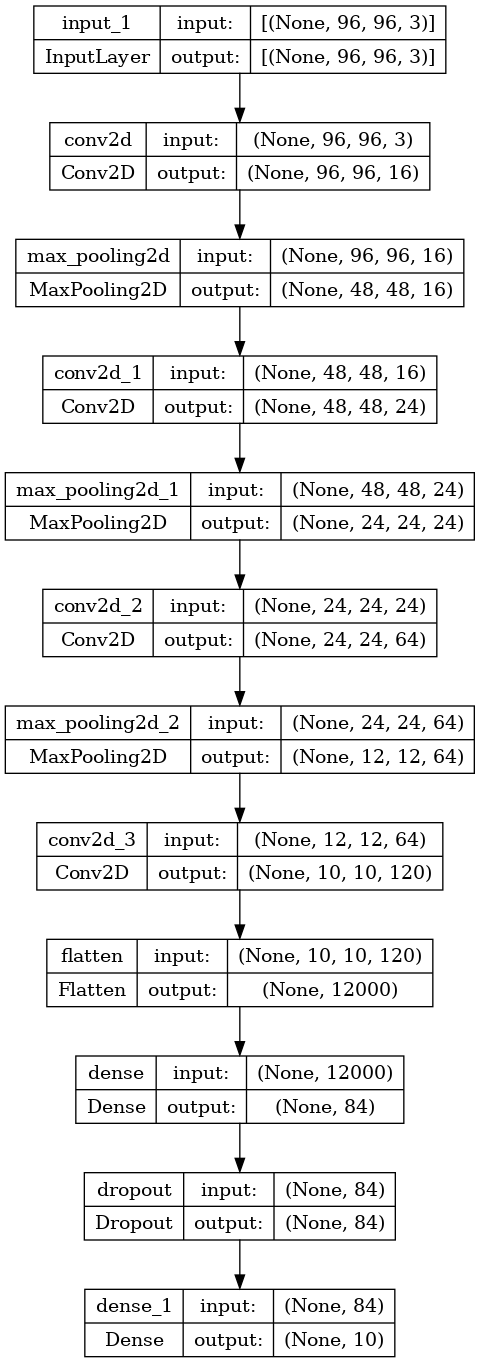

In [33]:
from keras.utils import plot_model

# visualizzazione del modello
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [34]:
model.summary()

Model: "basic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 24)        9624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        

Per implementare la rete come desiderato, utilizzando la distribuzione dei voti, è necessario definire una loss personalizzata che tratti la distribuzione dei voti umani come target. Si definisce poi un'accuracy su 3 macroclassi e un errore medio sulla previsione della classe con il numero più alto di voti.

In [154]:
# definizione della loss e compilazione

from tensorflow.keras import optimizers
from keras.optimizers import RMSprop, Adam

def custom_crossentropy(y_true, y_pred):
    # calcolo somma dei contributi per ogni classe
    entropia_dato = tf.reduce_sum(tf.multiply(tf.math.log(y_pred), y_true), axis=1)
    entropia = -entropia_dato
    return tf.reduce_mean(entropia)

def custom_accuracy(y_true, y_pred):
    # Calcolo degli indici degli elementi massimi
    pred_max_indices = tf.argmax(y_pred, axis=1) + 1
    # Calcolo delle medie arrotondate
    true_rounded_means = tf.round(tf.reduce_mean(y_true, axis=1))
    # Calcolo della frazione di elementi uguali
    accuracy = tf.reduce_mean(tf.cast(tf.less_equal(tf.abs(tf.cast(pred_max_indices, dtype=tf.float32) - true_rounded_means), 2), dtype=tf.float32))
    return accuracy

def custom_mean_error(y_true, y_pred):
    # Calcolo degli indici degli elementi massimi in y_true e y_pred
    true_max_indices = tf.argmax(y_true, axis=1)+1
    pred_max_indices = tf.argmax(y_pred, axis=1)+1
    # Calcolo dell'errore medio del batch
    error = tf.reduce_mean(tf.abs(true_max_indices - pred_max_indices))
    return error

def ad_accuracy(y_true, y_pred): #adjacent accuracy
    #raggruppo le probabilità in 3 classi
    #true_stacked = tf.stack([tf.reduce_sum(y_true[:, :3], axis=1), tf.reduce_sum(y_true[:, 3:6], axis=1), tf.reduce_sum(y_true[:, 6:], axis=1)], axis=1)
    #pred_stacked = tf.stack([tf.reduce_sum(y_pred[:, :3], axis=1), tf.reduce_sum(y_pred[:, 3:6], axis=1), tf.reduce_sum(y_pred[:, 6:], axis=1)], axis=1)
    #prendo quella con probabilità massima
    true_macroclass = tf.argmax(y_true, axis=1)
    pred_macroclass = tf.argmax(y_pred, axis=1)
    # Calcola l'accuratezza delle predizioni sulle macroclassi
    accuracy = tf.reduce_mean(tf.cast(tf.abs(true_macroclass - pred_macroclass) < 2, tf.float32))
    return accuracy


In [155]:
from keras.callbacks import Callback
from tensorflow.keras import backend as K

class LearningRateReducer(Callback):
    def __init__(self, initial_lr, reduce_factor, reduce_freq):
        super(LearningRateReducer, self).__init__()
        self.initial_lr = initial_lr
        self.reduce_factor = reduce_factor
        self.reduce_freq = reduce_freq

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.reduce_freq == 0 and epoch != 0:
            lr = K.get_value(self.model.optimizer.lr)
            new_lr = lr * self.reduce_factor
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f"Learning rate reduced to: {new_lr}")

# Definire i parametri
learning_rate = 0.0005
reduce_factor = 0.5
reduce_freq = 3

# Creare l'istanza della callback personalizzata
lr_reducer = LearningRateReducer(initial_lr=learning_rate, reduce_factor=reduce_factor, reduce_freq=reduce_freq)

# Compilazione del modello
model.compile(
    loss=custom_crossentropy,
    optimizer=RMSprop(learning_rate=learning_rate),
    metrics=[ad_accuracy, custom_mean_error]
)

# Allenamento del modello con la callback personalizzata
history = model.fit(
    train_features,
    train_target,
    epochs=20,
    batch_size=16,
    validation_data=(val_features, val_target),
    verbose=1,
    #callbacks=[lr_reducer]
)

Epoch 1/20
1344/1344 [==============================] - 247s 182ms/step - loss: 2.2898 - ad_accuracy: 0.4500 - custom_mean_error: 1.5737 - val_loss: 2.2019 - val_ad_accuracy: 0.5052 - val_custom_mean_error: 1.3533
Epoch 2/20
1344/1344 [==============================] - 244s 181ms/step - loss: 2.1688 - ad_accuracy: 0.5156 - custom_mean_error: 1.3147 - val_loss: 2.1594 - val_ad_accuracy: 0.5173 - val_custom_mean_error: 1.1933
Epoch 3/20
1344/1344 [==============================] - 243s 181ms/step - loss: 2.1524 - ad_accuracy: 0.5390 - custom_mean_error: 1.2329 - val_loss: 2.1401 - val_ad_accuracy: 0.5760 - val_custom_mean_error: 1.2000
Epoch 4/20
1344/1344 [==============================] - 243s 181ms/step - loss: 2.1408 - ad_accuracy: 0.5485 - custom_mean_error: 1.1890 - val_loss: 2.1359 - val_ad_accuracy: 0.5455 - val_custom_mean_error: 1.1667
Epoch 5/20
1344/1344 [==============================] - 242s 180ms/step - loss: 2.1321 - ad_accuracy: 0.5610 - custom_mean_error: 1.1399 - val_l

## Analisi dei risultati del training

Iniziamo a fare il grafico delle learning curves e delle metriche che abbiamo considerato

/tmp/ipykernel_32/1584115409.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


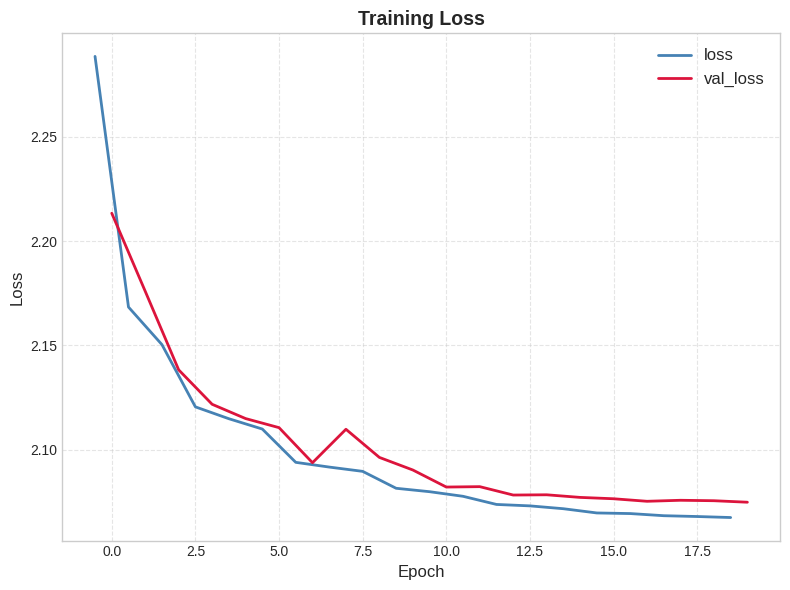

In [60]:
import matplotlib.pyplot as plt
# grafico loss
plt.style.use('seaborn-whitegrid')


fig, ax = plt.subplots(figsize=(8, 6))


metrics_to_plot = [metric for metric in history.history if metric not in ['ad_accuracy', 'val_ad_accuracy', 'custom_mean_error', 'val_custom_mean_error']]

colors = ['steelblue',  'crimson', 'orange', 'purple']

for i, metric in enumerate(metrics_to_plot):
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch) - 0.5, history.history[metric], label=metric, color=colors[i % len(colors)], linewidth=2)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric, color=colors[i % len(colors)], linewidth=2)

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

ax.legend(fontsize=12)

plt.title('Training Loss', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.savefig('class_loss.png', dpi=300)

plt.show()

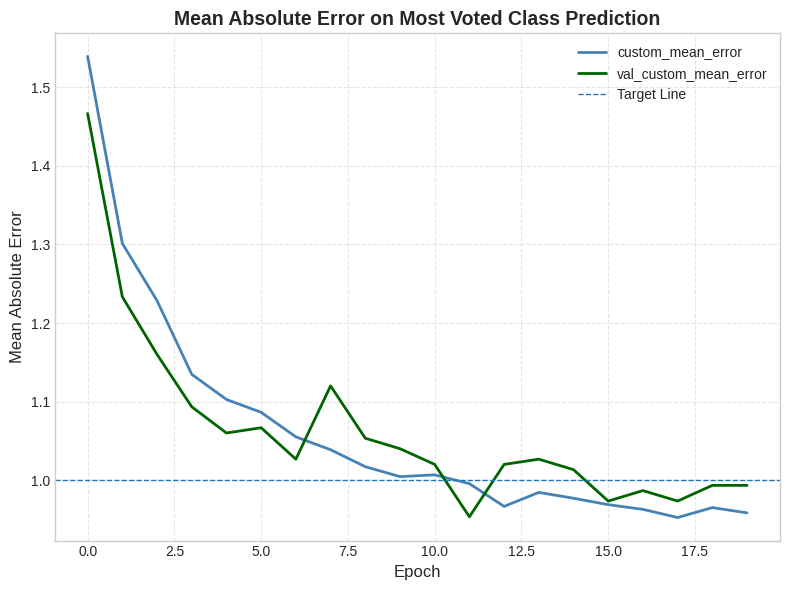

In [151]:
# grafico errore medio

fig, ax = plt.subplots(figsize=(8, 6))

metrics_to_plot = [metric for metric in history.history if metric not in ['loss', 'val_loss', 'ad_accuracy', 'val_ad_accuracy']]

colors = ['steelblue', 'darkgreen', 'crimson', 'orange', 'purple']

for i, metric in enumerate(metrics_to_plot):
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch) - 0.5, history.history[metric], label=metric, color=colors[i % len(colors)], linewidth=2)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric, color=colors[i % len(colors)], linewidth=2)

ax.axhline(y=1, linestyle='--', linewidth=1, label='Target Line')

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)

ax.legend(fontsize=10)

plt.title('Mean Absolute Error on Most Voted Class Prediction', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.savefig('mean_absolute_error_plot.png', dpi=300)

plt.show()

/tmp/ipykernel_32/3896426845.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


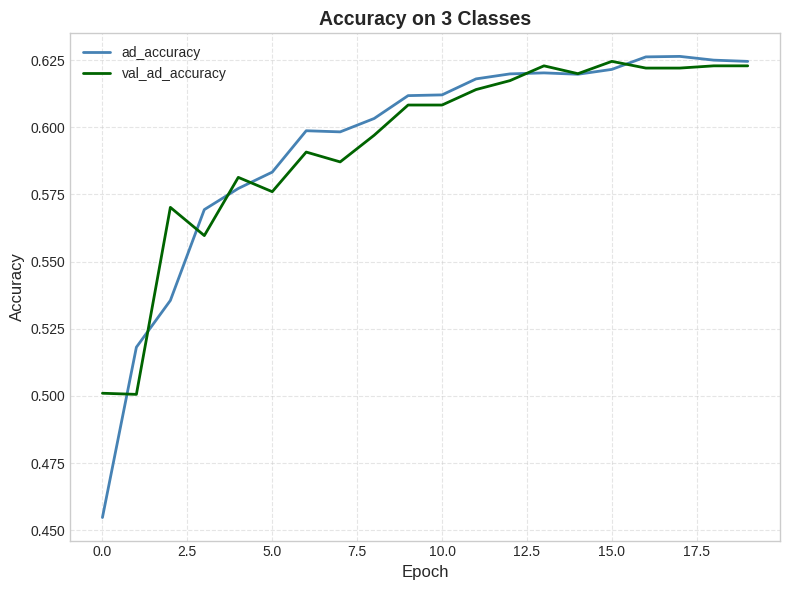

In [150]:
#grafico accuracy
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(8, 6))

metrics_to_plot = [metric for metric in history.history if metric not in ['loss', 'val_loss', 'custom_mean_error', 'val_custom_mean_error']]

colors = ['steelblue', 'darkgreen', 'crimson', 'orange', 'purple']

for i, metric in enumerate(metrics_to_plot):
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch) - 0.5, history.history[metric], label=metric, color=colors[i % len(colors)], linewidth=2)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric, color=colors[i % len(colors)], linewidth=2)

#ax.axhline(y=0.29, linestyle='--', color='black', linewidth=1, label='Null model')

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)

ax.legend(fontsize=10)

plt.title('Accuracy on 3 Classes', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.savefig('accuracy_3_classes_plot.png', dpi=300)

plt.show()

# Valutazione performance

In [63]:
# valutazione sul test set

test_loss, test_acc, test_error = model.evaluate(test_features, test_target)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)
print('Test Error:\t', test_error)

187/187 [==============================] - 16s 85ms/step - loss: 2.0679 - ad_accuracy: 0.6278 - custom_mean_error: 0.9786

Test Loss:	 2.06787371635437
Test Accuracy:	 0.6278074979782104
Test Error:	 0.9786096215248108


In [64]:
y_test_pred = model.predict(test_features)

187/187 [==============================] - 16s 85ms/step


In [65]:
# clacolo anche top2 accuracy

top2acc = np.mean(np.any(np.argsort(y_test_pred, axis=1)[:, -3:] == np.argmax(test_target, axis=1).reshape(-1, 1), axis=1))
top2acc


0.6445077026121903

Vediamo visivamente le prime 10 foto predette in classe 10 e le prime 10 predette in classe 1

In [98]:
# foto con piu alta probabilità sull'ultima classe

top_indices = np.where(np.argmax(y_test_pred, axis=1) == 0)[0]

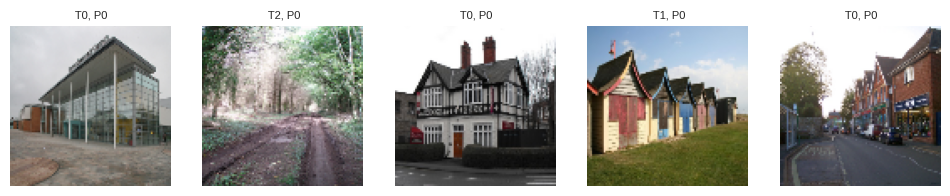

In [99]:
fig, axs = plt.subplots(1,5,figsize=(12,4))

for i in range(5):
    
    ax = axs.ravel()[i]
    
    idx = top_indices[i]
    
    ax.imshow(test_features[idx], cmap='gray')
    ax.set_title(' T{}, P{}'.format(np.argmax(test_target[idx]), np.argmax(y_test_pred[idx])), fontsize=8)
    ax.axis('off')
    
fig.savefig('5_1.png', dpi=300)

Vediamo ora 10 immagini a caso del test set e le loro distribuzioni

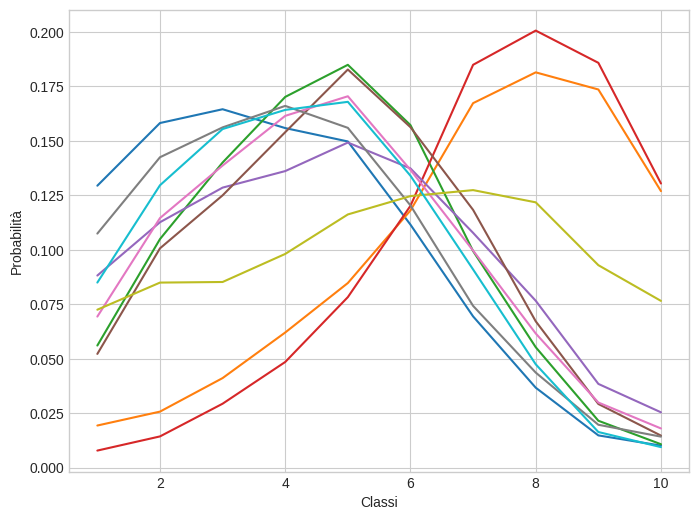

In [125]:
random_rows = np.random.choice(y_test_pred.shape[0], size=10, replace=False)

# Estrazione delle righe selezionate
selected_rows = y_test_pred[random_rows]

# Plot delle righe selezionate
x = np.arange(1, 11)  # Range da 1 a 10 per l'asse x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(selected_rows.shape[0]):
    ax.plot(x, selected_rows[i])

ax.set_xlabel('Classi')
ax.set_ylabel('Probabilità')

ax.grid(True)

plt.savefig('10distr.png', dpi=300)

plt.show()

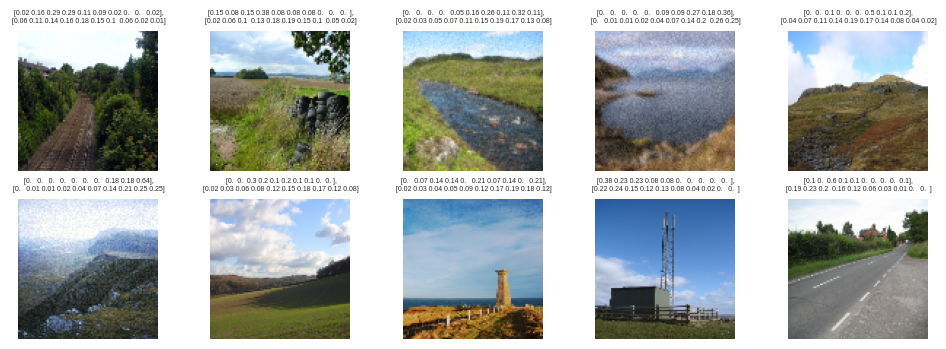

In [112]:
fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = random_rows[i]
    
    ax.imshow(test_features[idx], cmap='gray')
    ax.set_title(' {},\n {}'.format(np.round(test_target[idx],decimals=2), np.round(y_test_pred[idx],decimals=2)), fontsize=5)
    ax.axis('off')

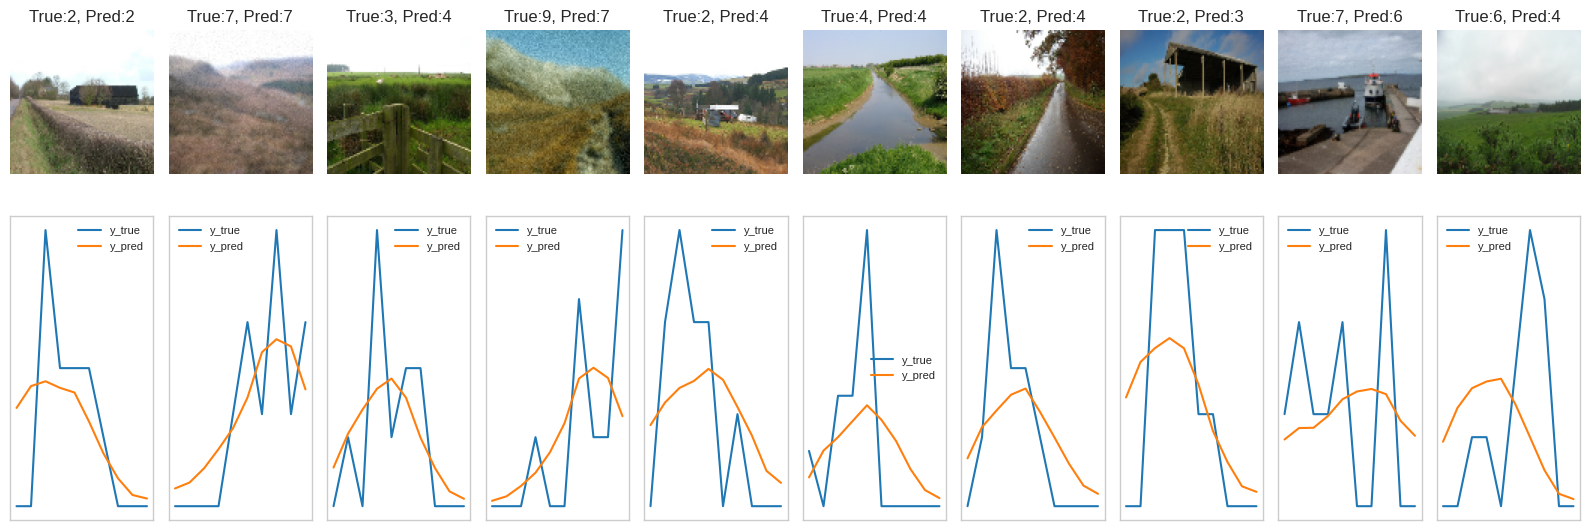

In [126]:
fig, axs = plt.subplots(2, 10, figsize=(16, 6))

for i in range(10):
    ax = axs[0, i]
    idx = random_rows[i]
    
    ax.imshow(test_features[idx], cmap='gray')
    ax.set_title('True:{}, Pred:{}'.format(np.argmax(test_target[idx]), np.argmax(y_test_pred[idx]), fontsize=7))
    ax.axis('off')

    # Creazione di un secondo subplot per i plot di y_true e y_pred

    ax2 = axs[1, i]
    ax2.plot(test_target[idx], label='y_true')
    ax2.plot(y_test_pred[idx], label='y_pred')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.legend(fontsize=8)

plt.tight_layout()

plt.savefig('rand_distr_img.png', dpi=300)

plt.show()

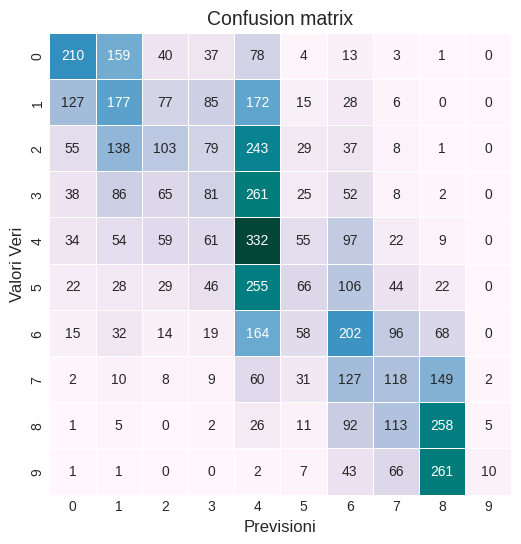

In [127]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcolare la matrice di confusione
confusion_mat = confusion_matrix(np.argmax(test_target, axis=1), np.argmax(y_test_pred, axis=1))

# Creare la figura e l'asse dei grafici
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="PuBuGn", cbar=False, square=True, linewidths=0.5)

# Aggiungere etichette agli assi
class_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.xlabel("Previsioni", fontsize=12)
plt.ylabel("Valori Veri", fontsize=12)
#plt.xticks(np.arange(len(class_labels)), class_labels, fontsize=10)
#plt.yticks(np.arange(len(class_labels)), class_labels, fontsize=10)

# Aggiungere titolo e riquadro
plt.title("Confusion matrix", fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('cm_10.png')

# Mostrare la matrice di confusione
plt.show()

Vedere dove sbaglia di più

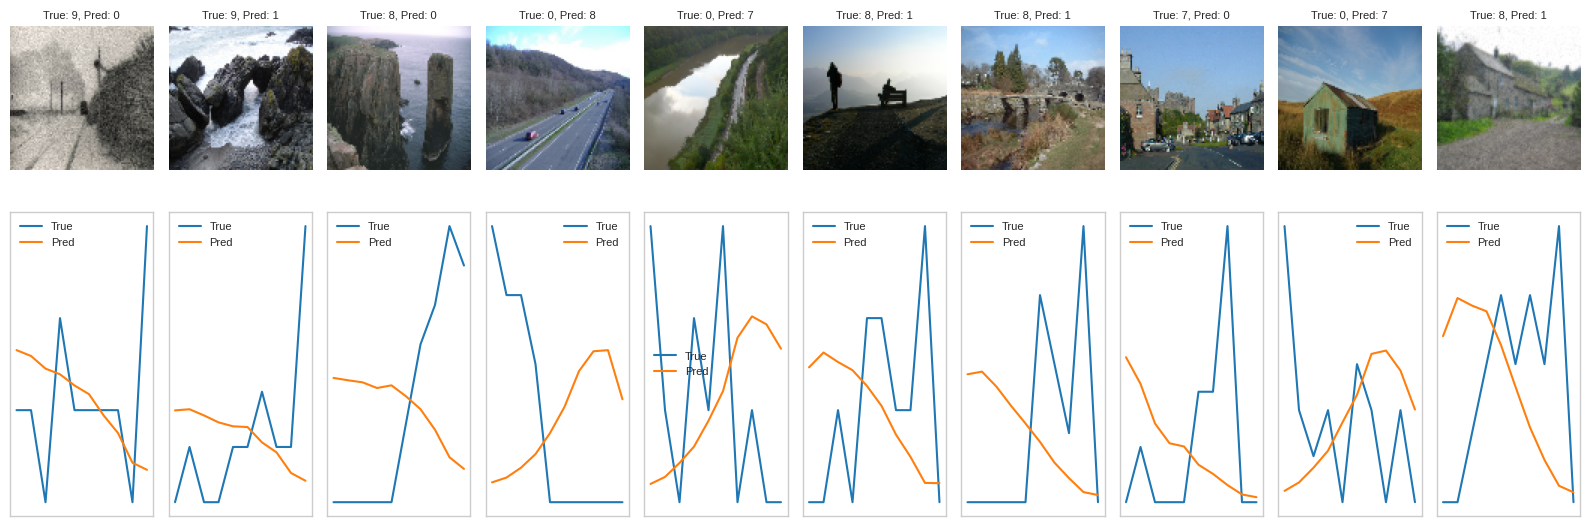

In [128]:
max_pred_indices = np.argmax(y_test_pred, axis=1)  # Indici delle massime predizioni
max_label_indices = np.argmax(test_target, axis=1)  # Indici delle massime label

differences = np.abs(max_pred_indices - max_label_indices)

max_errors = np.argsort(differences)[::-1][:10] 

fig, axs = plt.subplots(2, 10, figsize=(16, 6))

for i in range(10):
    ax = axs[0, i]
    idx = max_errors[i]
    
    ax.imshow(test_features[idx], cmap='gray')
    ax.set_title('True: {}, Pred: {}'.format(max_label_indices[idx], max_pred_indices[idx]), fontsize=8)
    ax.axis('off')

    # Creazione di un secondo subplot per i plot di y_true e y_pred

    ax2 = axs[1, i]
    ax2.plot(test_target[idx], label='True')
    ax2.plot(y_test_pred[idx], label='Pred')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.legend(fontsize=8)

plt.tight_layout()
plt.savefig('10+sbagliate.png', dpi=300)
plt.show()

## Valutazione quantitativa

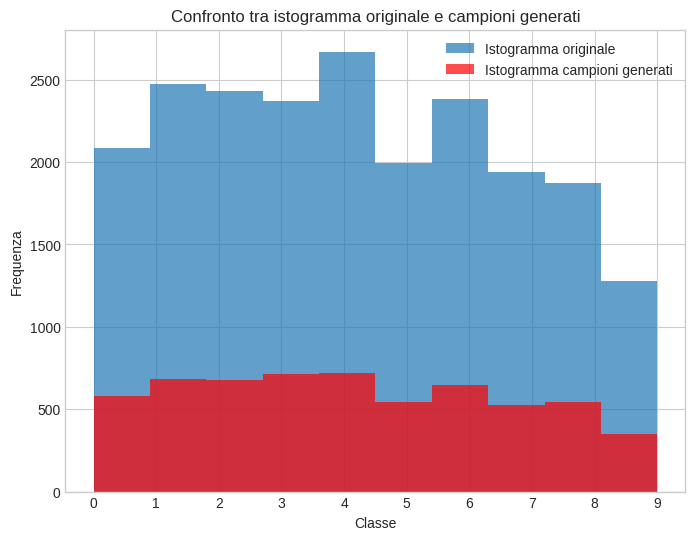

In [129]:
#istogramma per il modello nullo

unique_values, counts = np.unique(np.argmax(train_target, axis=1), return_counts=True)
total_counts = np.sum(counts)
probabilities = counts / total_counts

# Generazione di n campioni basati sull'istogramma
n = len(test_target)
samples = np.random.choice(np.arange(10), size=n, p=probabilities)

# Calcolo dell'istogramma dei campioni generati
sample_histogram, _ = np.histogram(samples, bins=np.arange(11))

# Plot dell'istogramma originale
plt.figure(figsize=(8, 6))
plt.hist(np.argmax(train_target, axis=1), alpha=0.7, label='Istogramma originale')


plt.xlabel('Classe')
plt.ylabel('Probabilità')

plt.title('Confronto tra istogramma originale e campioni generati')


# Plot dei campioni generati

plt.hist(samples, alpha=0.7,  color='red', label='Istogramma campioni generati')
plt.xlabel('Classe')
plt.ylabel('Frequenza')
plt.xticks(np.arange(10))
plt.legend()

plt.savefig('distr_approx.png', dpi=300)

plt.show()

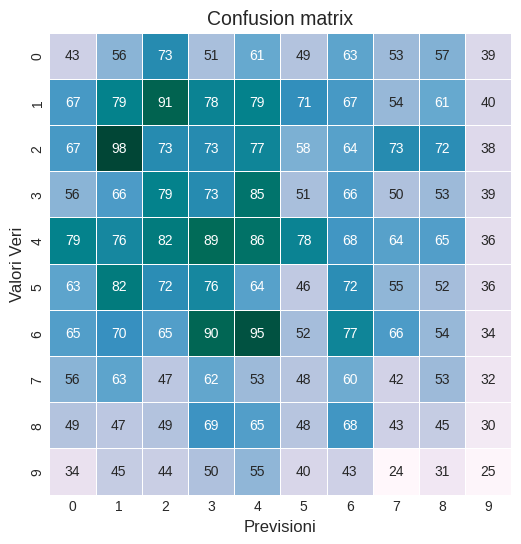

In [130]:
# errore del modello nullo

# Calcolare la matrice di confusione
confusion_mat = confusion_matrix(np.argmax(test_target, axis=1), samples)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="PuBuGn", cbar=False, square=True, linewidths=0.5)

# Aggiungere etichette agli assi
class_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.xlabel("Previsioni", fontsize=12)
plt.ylabel("Valori Veri", fontsize=12)

# Aggiungere titolo e riquadro
plt.title("Confusion matrix", fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('cm_10random.png')

# Mostrare la matrice di confusione
plt.show()

In [131]:
# calcolo frazione di previsioni che distano tra loro più di 

def plot_distance_curve(vec1, vec2):
    # Calcola le distanze tra i vettori
    distanze = np.abs(vec1 - vec2)
    
    # Calcola la frazione di elementi con distanza maggiore di x
    distanze_ordinate = np.sort(distanze)
    frazione = np.arange(1, len(distanze_ordinate) + 1) / len(distanze_ordinate)
    
    plt.plot(distanze_ordinate, frazione)

    #linea per raggiungimento 90% valori
    indice_90_percento = np.argmax(frazione >= 0.9)
    plt.axvline(x=distanze_ordinate[indice_90_percento], color='r', linestyle='--', label='90%')

    plt.xlabel('Distanza')
    plt.ylabel('Frazione')
    plt.title('Curva della frazione di elementi per distanza')

    plt.show()

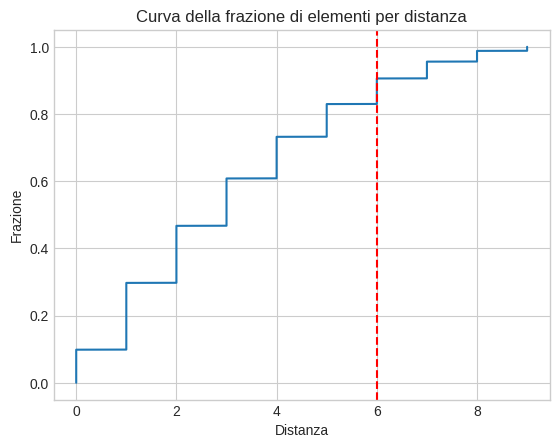

In [132]:
plot_distance_curve(samples, np.argmax(test_target, axis=1))

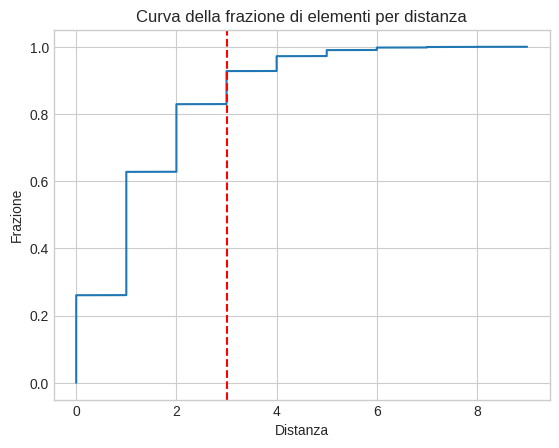

In [133]:
plot_distance_curve(np.argmax(y_test_pred, axis=1), np.argmax(test_target, axis=1))

Quantificare quanto meglio del modello nullo sto facendo

In [137]:
# errore medio modello nullo

acc_null=tf.reduce_mean(tf.cast(tf.math.less(np.abs(np.argmax(test_target,axis=1)-samples),2), tf.float32))
acc_null

<tf.Tensor: shape=(), dtype=float32, numpy=0.2973878>

In [139]:
acc_model=tf.reduce_mean(tf.cast(tf.math.less(np.abs(np.argmax(test_target,axis=1)-np.argmax(y_test_pred,axis=1)),2), tf.float32))
acc_model

<tf.Tensor: shape=(), dtype=float32, numpy=0.6277629>

In [140]:
perc_miglioramento = (acc_model - acc_null) / acc_null * 100
perc_miglioramento

<tf.Tensor: shape=(), dtype=float32, numpy=111.092354>

In [102]:
acc_null=tf.reduce_mean(tf.cast(tf.math.less(np.abs(np.argmax(test_target,axis=1)-samples),1), tf.float32))
acc_null

<tf.Tensor: shape=(), dtype=float32, numpy=0.100133955>

In [103]:
acc_model=tf.reduce_mean(tf.cast(tf.math.less(np.abs(np.argmax(test_target,axis=1)-np.argmax(y_test_pred,axis=1)),1), tf.float32))
acc_model

<tf.Tensor: shape=(), dtype=float32, numpy=0.28248492>

In [104]:
perc_miglioramento = (acc_model - acc_null) / acc_null * 100
perc_miglioramento

<tf.Tensor: shape=(), dtype=float32, numpy=182.10703>

## Ulteriori metriche


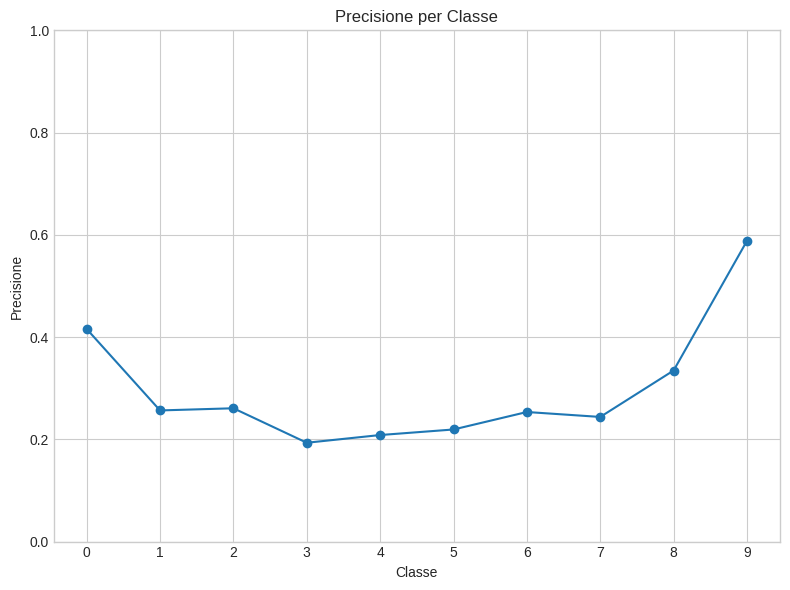

In [142]:
from sklearn.metrics import precision_score

# Calcolare la precisione per ciascuna classe
precision_per_class = []
for class_idx in range(10):
    y_true = np.argmax(test_target, axis=1)
    y_pred = np.argmax(y_test_pred, axis=1)
    precision = precision_score(y_true, y_pred, average=None)[class_idx]
    precision_per_class.append(precision)

# Creare il grafico della precisione per ciascuna classe
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.figure(figsize=(8, 6))
plt.plot(range(10), precision_per_class, marker='o')
plt.xticks(range(10), class_labels)
plt.xlabel('Classe')
plt.ylabel('Precisione')
plt.title('Precisione per Classe')
plt.ylim([0, 1])  # Imposta il limite dell'asse y tra 0 e 1 (range di precisione)
plt.grid(True)  # Aggiungi una griglia di sfondo
plt.tight_layout()  # Regola automaticamente le etichette degli assi
plt.savefig('precision.png')
plt.show()

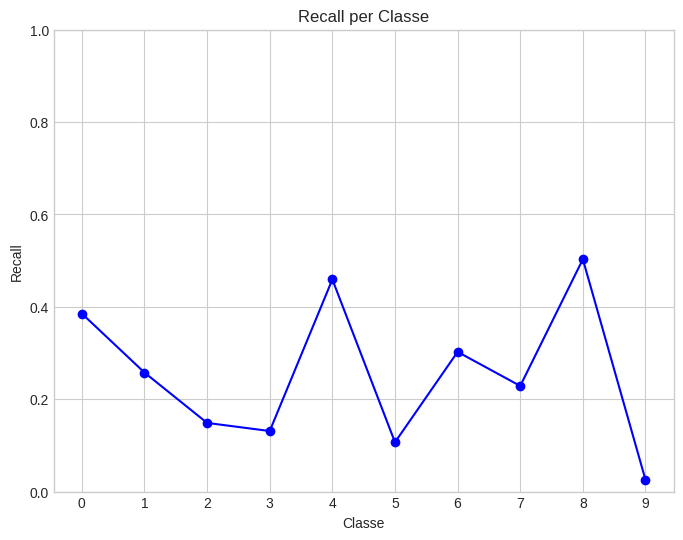

In [143]:
from sklearn.metrics import recall_score

# Calcolare la recall per ogni classe
recall_per_class = recall_score(np.argmax(test_target, axis=1), np.argmax(y_test_pred, axis=1), average=None)

# Creare il grafico
class_labels = np.arange(10)  # Etichette delle classi da 0 a 9
plt.figure(figsize=(8, 6))
plt.plot(class_labels, recall_per_class, marker='o', linestyle='-', color='b')
plt.xlabel("Classe")
plt.ylabel("Recall")
plt.title("Recall per Classe")
plt.xticks(class_labels)
plt.ylim([0, 1])  # Impostare il limite dell'asse y da 0 a 1
plt.grid(True)

plt.savefig('recall.png')

# Mostrare il grafico
plt.show()

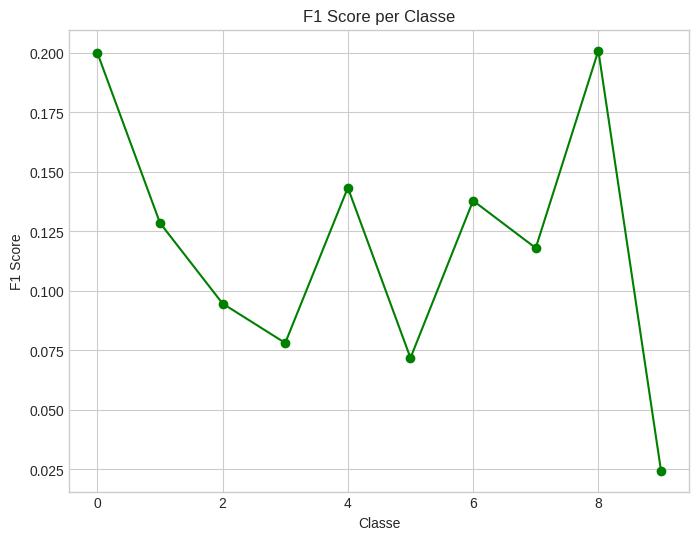

In [148]:
from sklearn.metrics import f1_score

# Calcolo dell'F1 score per ciascuna classe
f1_scores = recall_per_class*precision_per_class/(recall_per_class+precision_per_class)

# Creazione del grafico
plt.figure(figsize=(8, 6))
plt.plot(class_labels, f1_scores, marker='o', linestyle='-', color='g')
plt.xlabel("Classe")
plt.ylabel("F1 Score")
plt.title("F1 Score per Classe")
plt.savefig('f1.png')
plt.show()